In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
sns.set()

from statsmodels.tsa.seasonal import seasonal_decompose as decompose
from pandas import Series
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime as dt
from matplotlib.pyplot import figure
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
env = 'Colab'#'Colab'
path = '.'

if env == 'Colab':
    from google.colab import drive
    drive.mount('/content/drive')
    !ls drive/MyDrive/Dataset
    path = 'drive/MyDrive'

features = pd.read_csv(f'{path}/Dataset/dengue_features_train.csv')
features.week_start_date = pd.to_datetime(features.week_start_date) # Converting the date into a date time object

cases = pd.read_csv(f'{path}/Dataset/dengue_labels_train.csv')

# Performing an Inner Join on the dataset on the common columns
df = pd.merge(features, cases, on = ["year", "weekofyear", "city"])
df.index = df.week_start_date
df.head()
df.tail()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dengue_features_test.csv      dengue_labels_train.csv
dengue_features_train.csv     dengue_labels_train.gsheet
dengue_features_train.gsheet  submission_format.csv


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-05-28,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
2010-06-04,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
2010-06-11,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
2010-06-18,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1
2010-06-25,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,299.835714,295.807143,307.8,292.3,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4,4


25 25
Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')
25 25
Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_rel

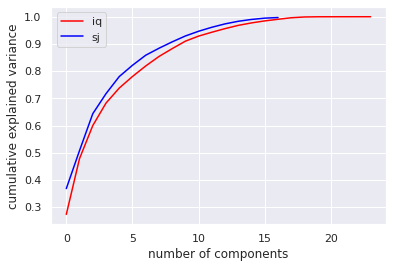

In [ ]:
def pcaAnalysis(dfs_list,num_components): #work on the imputed data
    dfs,original_dfs = dfs_list

    for i,x in enumerate(dfs):
        print(len(original_dfs[i].columns),len(x.columns))
        print(x.columns)

    # for i in range(len(dfs)):
    #     try:
    #         dfs[i].drop(['weekofyear','year'],axis=1,inplace=True)
    #     except Exception as e:
    #         print(e)

    #     try:
    #         dfs[i].drop(['month'],axis=1,inplace=True)
    #     except Exception as e:
    #         print(e)
        

    details = {
        0:['iq','red'],
        1:['sj','blue']
    }

    sc = StandardScaler()
    pca = PCA()
    res = []
    
    #number of components to keep can be explained with the help of 
    #explained variance ratio as a function of the number of components
    #it is the percentage of variance attributed to each of the selected component
    #hence we shld go on adding components until the total variance ratio is upto 80% or so to avoid overfitting

    for df_indx,adf in enumerate(dfs):
        adf = adf.drop('city',1)
        
        #convert datetime to ordinal value from datetime object for normalization
        adf['week_start_date'] = adf['week_start_date'].map(dt.datetime.toordinal)
        try:
            adf = sc.fit_transform(adf)
            adf_pca = pca.fit(adf)
        except Exception as e:
            print(e)
            print(adf)
        
        
        plt.plot(
            np.cumsum(pca.explained_variance_ratio_),
            label = details[df_indx][0],
            color = details[df_indx][1],
        )

        pca = PCA(num_components)
        adf_pca = pca.fit_transform(adf)

        #get the most important features
        #pca.components_ is a list of eigenvector magnitudes for each priciple component
        most_imp = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
        most_imp_names = [original_dfs[df_indx].columns[most_imp[i]] for i in range(pca.n_components_)]
        res.append(most_imp_names)

    plt.xlabel("number of components")
    plt.ylabel('cumulative explained variance')
    plt.legend()
    plt.plot()
    return res

important_columns = pcaAnalysis([
                                 [iq_df_imputed,sj_df_imputed],
                                 [iq_df,sj_df]
                            ],15+2)

In [ ]:
#ordinal value encoder object
ENC = OrdinalEncoder()
#scaling object for training dataset
boostSC = None
#scaling object for testing objectdataset
testSC = None

In [ ]:
def cityToNumeric(city):
    global ENC
    city_enc = ENC.fit_transform(city.values.reshape(-1,1))
    return city_enc

In [ ]:
def scale_me(boostSc,dataX,dataY):
    dataXY = boostSc.transform(pd.concat([dataX,dataY],axis=1))
    print(dataXY.shape,type(dataXY))
    return dataXY[:,0:-1],dataXY[:,-1]

In [ ]:
def adaboostModel(boostdf,important_columns):
    #drop unwanted column
    boostdf = boostdf.drop(['weekofyear','week_start_date'],axis=1)

    #encode city to numeric value so that we can normalize it
    boostdf['city'] = cityToNumeric(boostdf['city'])
    
    #extract table subset comprising of needed columns only
    pca_cols = list(set(important_columns) - set(['weekofyear','week_start_date','year']))+['city']
    newBoostdf = boostdf[pca_cols+['total_cases']]

    #features and label
    data_y = newBoostdf['total_cases']
    data_x = boostdf[pca_cols]

    #trainig  and validation set
    train_x,val_x,train_y,val_y= train_test_split(data_x,data_y,test_size=0.1,shuffle=False)

    #original validation label
    orig_val_y = val_y

    #scale the data
    boostSc = StandardScaler().fit(newBoostdf)
    global boostSC
    boostSC = boostSc

    train_x,train_y = scale_me(boostSc,train_x,train_y)
    val_x,val_y = scale_me(boostSc,val_x,val_y)

    #adaboost model
    model = AdaBoostRegressor(base_estimator=GradientBoostingRegressor(
    max_depth=5, 
    min_samples_split=2, 
    loss='squared_error',n_estimators=400, 
    learning_rate=.1, random_state=1)).fit(train_x,train_y)
    
    print(model.score(train_x,train_y))

    #validation
    y_hat = model.predict(val_x)
    #cocatenate both the numpy matrices to get the original shape dataframe fr inverse transformation
    y_pred = np.reshape(y_hat,(y_hat.shape[0],1))
    res = np.concatenate((val_x,y_pred),axis=1)
    y_sub = boostSC.inverse_transform(
        res
    )
    y_final = np.abs(y_sub[:,-1].astype(int))
    results = pd.DataFrame({
        "actual":list(orig_val_y),
        "prediction":y_final
    })
    print(mean_absolute_error(y_final,orig_val_y))
    return results,model

In [ ]:
def testModel(path,sj_df_imputed,iq_df_imputed):
    #create combined dataset
    boostdf = sj_df_imputed
    boostdf = boostdf.append(iq_df_imputed)

    return adaboostModel(boostdf,important_columns[0])

In [ ]:
sj_df = df[df["city"] == 'sj']
iq_df = df[df["city"] == 'iq']

In [ ]:
def imputeMissing(dfs):
    print(len(dfs[0].columns),len(dfs[-1].columns))
    for adf in dfs:
        for col in adf.columns[adf.isna().any()].tolist():
            adf[col].interpolate(method="time",inplace=True)
    return iq_df,sj_df

iq_df_imputed,sj_df_imputed = imputeMissing([iq_df,sj_df])

25 25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
cross_val_df,model = testModel(path,sj_df_imputed,iq_df_imputed)

(1310, 13) <class 'numpy.ndarray'>
(146, 13) <class 'numpy.ndarray'>
0.9946045891355192
9.116438356164384


In [ ]:
print(cross_val_df)

     actual  prediction
0         7           6
1         5           2
2         2           6
3         6          11
4        11          15
..      ...         ...
141       5          20
142       8           5
143       1          11
144       1           1
145       4           7

[146 rows x 2 columns]
